In [5]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [6]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('C:\\Users\\Admin\\Downloads\\ACB.csv')
df1=df.reset_index()['Close']
df1 = df1.str.replace(',', '').astype(float)

In [7]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [9]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [12]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [13]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100

15/15 [==============================] - 15s 219ms/step - loss: 0.0690
Epoch 2/100
15/15 [==============================] - 3s 188ms/step - loss: 0.0092
Epoch 3/100
15/15 [==============================] - 3s 222ms/step - loss: 0.0042
Epoch 4/100
15/15 [==============================] - 3s 220ms/step - loss: 0.0029
Epoch 5/100
15/15 [==============================] - 3s 180ms/step - loss: 0.0028
Epoch 6/100
15/15 [==============================] - 3s 188ms/step - loss: 0.0027
Epoch 7/100
15/15 [==============================] - 3s 180ms/step - loss: 0.0027
Epoch 8/100
15/15 [==============================] - 3s 190ms/step - loss: 0.0026
Epoch 9/100
15/15 [==============================] - 3s 170ms/step - loss: 0.0027
Epoch 10/100
15/15 [==============================] - 3s 173ms/step - loss: 0.0027
Epoch 11/100
15/15 [==============================] - 2s 165ms/step - loss: 0.0027
Epoch 12/100
15/15 [==============================] - 3s 200ms/step - loss: 0.0025
Epoch 13/10

In [14]:
# 10. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)

11/11 [==============================] - 19s 112ms/step


In [15]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)

In [16]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 12321.749410431084


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input = np.array(x_input)
temp_input = list(x_input[0])
lst_output = []

n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1


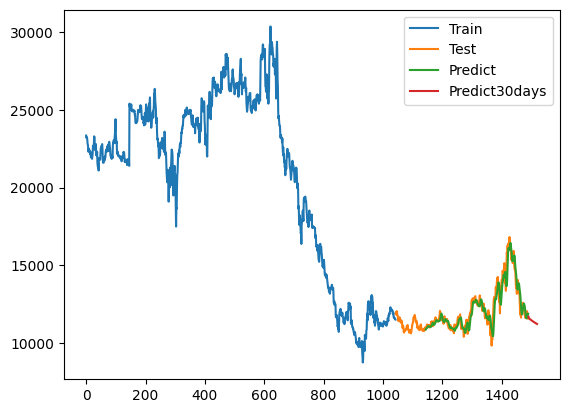

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()